# Data Model for Object Detection
The task here is to prepare a TFRecord dataset that can be fed into the [object detection API of tensorflow](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook uses a subset of the [GSSS](https://datadryad.org/resource/doi:10.5061/dryad.5pt92) dataset that were used in this [paper](https://datadryad.org/resource/doi:10.5061/dryad.5pt92) by Schneider! <br> 
I broke down the data model into the following steps:<br>
1. Database creation - As part of this step I work on consolidating the input data in various format into a one json file.
2. Using this json to create a tensorflow record
3. Validating the pipeline


The detailed steps that I follow are:
1. Data Export : CSV -> JSON
2. Data Import : JSON -> CSV 
3. Create test train spit
4. Write TFRecord : JSON -> TFRecord
5. Data import for Schneider
6. Check data

## Importing necessary packages

In [1]:
#import pandas as pd
import csv, os, sys
import operator
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
sys.path.append('/home/rai00007/Desktop/zooniverse/Data/')
from utils import dataset_util
#Added this to handle the truncation error while decoding the jpeg
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
Project_filepath = "/home/rai00007/Desktop/zooniverse/Data/images/"# "/data/lucifer1.2/users/rai00007/"

In [3]:
"""creating a list of all GSSS images used by Schneider"""
import glob
lst = (glob.glob("/home/rai00007/Desktop/zooniverse/Data/images/*.jpg"))
lst2 = []
for l in lst:
    lst2.append(l[-14:]) #list of all images that schnider used

In [4]:
gold_standard_bb = {}
with open('/home/rai00007/Desktop/zooniverse/Data/GoldStandardBoundBoxCoord.csv', 'r') as csvfile:
    csvdata = csv.reader(csvfile, delimiter=',')
    header = next(csvdata)
    col_mapper = {k: i for i, k in enumerate(header)}
    for i, row in enumerate(csvdata):
        filename = row[col_mapper['filename']]
        if filename in lst2: #including only the images that were used by Schneider
            if filename not in gold_standard_bb.keys():
                gold_standard_bb[filename] = []
            gold_standard_bb[filename].append({k: row[v] for k, v in col_mapper.items() })
            if i%5000 == 0:
                print("performing iteration : %s" % i)

performing iteration : 0
performing iteration : 5000
performing iteration : 10000
performing iteration : 15000


In [5]:
all_images = {}
with open('/home/rai00007/Desktop/zooniverse/Data/all_images.csv', 'r') as csvfile:
    csvdata = csv.reader(csvfile, delimiter=',')
    header = next(csvdata)
    col_mapper = {k: i for i, k in enumerate(header)}
    for i, row in enumerate(csvdata):
        filename = row[col_mapper['CaptureEventID']]
        if filename not in all_images.keys():
            all_images[filename] = []
        all_images[filename].append({k: row[v] for k, v in col_mapper.items() })
        if i%50000 == 0:
            print("performing iteration : %s" % i)

performing iteration : 0
performing iteration : 50000
performing iteration : 100000
performing iteration : 150000
performing iteration : 200000
performing iteration : 250000
performing iteration : 300000
performing iteration : 350000
performing iteration : 400000
performing iteration : 450000
performing iteration : 500000
performing iteration : 550000
performing iteration : 600000
performing iteration : 650000
performing iteration : 700000
performing iteration : 750000
performing iteration : 800000
performing iteration : 850000
performing iteration : 900000
performing iteration : 950000
performing iteration : 1000000
performing iteration : 1050000
performing iteration : 1100000
performing iteration : 1150000
performing iteration : 1200000
performing iteration : 1250000
performing iteration : 1300000
performing iteration : 1350000
performing iteration : 1400000
performing iteration : 1450000
performing iteration : 1500000
performing iteration : 1550000
performing iteration : 1600000
per

In [6]:
consensus_data = {}
with open(os.path.join(Project_filepath, '/home/rai00007/Desktop/zooniverse/Data/consensus_data.csv'), 'r') as csvfile:
    csvdata = csv.reader(csvfile, delimiter=',')
    header = next(csvdata)
    col_mapper = {k: i for i, k in enumerate(header)}
    for i, row in enumerate(csvdata):
        filename = row[col_mapper['CaptureEventID']]
        if filename not in consensus_data.keys():
            consensus_data[filename] = []
        consensus_data[filename].append({k: row[v] for k, v in col_mapper.items() })
        if i%50000 == 0:
            print("performing iteration : %s"% i)

performing iteration : 0
performing iteration : 50000
performing iteration : 100000
performing iteration : 150000
performing iteration : 200000
performing iteration : 250000
performing iteration : 300000


CaptureEventID - Consensus Data <br>
Metadata {SiteID, Location, Datetime} - Consensus Data <br>
Images [{ path} - all_images, dimension - GoldStandardBoundBoxCoord] <br>
Observation [bounding box] - GoldStandardBoundBoxCoord

##### Helper functions

In [7]:
"""This function reads a raw image, resizes it with aspect ratio preservation and returns the byte string"""
from PIL import Image
import numpy as np
import io



def resize_jpeg(image,  max_side):
    """ Take Raw JPEG resize with aspect ratio preservation
         and return bytes
    """
    img = Image.open(image)
    img.thumbnail([max_side, max_side], Image.ANTIALIAS)
    b = io.BytesIO()
    img.save(b, 'JPEG')
    image_bytes = b.getvalue()
    return image_bytes

In [8]:
# Bad function! To be changed 
def class_text_to_int(row_label):

    if row_label == 'Aardwolf': return 1
    elif row_label == 'Aardvark': return 2
    elif row_label == 'Baboon': return 3
    elif row_label == 'Buffalo': return 4
    elif row_label == 'BuffaloYouth': return 5
    elif row_label == 'BuffCrestedBustard': return 6
    elif row_label == 'Bushbuck': return 7
    elif row_label == 'CattleEgret': return 8 #CatteEgret
    elif row_label == 'Cheetah': return 9
    elif row_label == 'DikDik': return 10
    elif row_label == 'DistantAnimal': return 11
    elif row_label == 'Eland': return 12
    elif row_label == 'Elephant': return 13
    elif row_label == 'ElephantYouth': return 14
    elif row_label == 'GazelleGrants': return 15
    elif row_label == 'GazelleGrantsFemale': return 16
    elif row_label == 'GazelleGrantsMale': return 17
    elif row_label == 'GazelleThomsons': return 18
    elif row_label == 'GazelleThomsonsFemale': return 19
    elif row_label == 'GazelleThomsonsMale': return 20
    elif row_label == 'GazelleThomsonsYouth': return 21
    elif row_label == 'Giraffe': return 22
    elif row_label == 'GreyBackedFiscal': return 23
    elif row_label == 'GuineaFowl': return 24
    elif row_label == 'GuineaFowlYouth': return 25
    elif row_label == 'Hare': return 26
    elif row_label == 'Hartebeest': return 27
    elif row_label == 'Hippopotamus': return 28
    elif row_label == 'HotAirBalloon': return 29
    elif row_label == 'Human': return 30
    elif row_label == 'HyenaSpotted': return 31
    elif row_label == 'Impala': return 32
    elif row_label == 'ImpalaFemale': return 33
    elif row_label == 'ImpalaMale': return 34
    elif row_label == 'ImpalaYouth': return 35
    elif row_label == 'Jackal': return 36
    elif row_label == 'KoriBustard': return 37
    elif row_label == 'Leopard': return 38
    elif row_label == 'LionFemale': return 39 
    elif row_label == 'LionMale': return 40
    elif row_label == 'Mongoose': return 41
    elif row_label == 'Ostrich': return 42
    elif row_label == 'OtherBird': return 43
    elif row_label == 'Oxpecker': return 44
    elif row_label == 'Porcupine': return 45
    elif row_label == 'Reedbuck': return 46
    elif row_label == 'ReedbuckMale': return 47
    elif row_label == 'ReedbuckFemale': return 48
    elif row_label == 'ReedbuckYouth': return 49
    elif row_label == 'Rhinoceros': return 50
    elif row_label == 'Rodent': return 51
    elif row_label == 'SecretaryBird': return 52
    elif row_label == 'Serval': return 53
    elif row_label == 'SpottedHyena': return 54
    elif row_label == 'Stork': return 55
    elif row_label == 'SuperbStarling': return 56
    elif row_label == 'Topi': return 57
    elif row_label == 'TopiMale': return 58
    elif row_label == 'TopiFemale': return 59
    elif row_label == 'Truck': return 60
    elif row_label == 'VervetMonkey': return 61
    elif row_label == 'Warthog': return 62
    elif row_label == 'Waterbuck': return 63
    elif row_label == 'WattledStarling': return 64
    elif row_label == 'WhiteHeadBuffaloWeaver': return 65
    elif row_label == 'Wildebeest': return 66
    elif row_label == 'WildebeestYouth': return 67
    elif row_label == 'Zebra': return 68
    elif row_label == 'ZebraYouth': return 69
    else : return 101 # Temporary bug fixed. Not good for model training
#     else: print('unlabelled!', row_label)

In [9]:
#%%writefile data/data_model.py

"""This function takes the GSSS bounding box dataset published by in the paper
    and converts it into a dictionary object. The column names in the CSV has to maintained"""
def csvtodict(Project_filepath, bb_data, concensus_data, all_images_data, images):
    lst = []
    event_dict = {}
    csvfile = open(os.path.join(Project_filepath, bb_data), 'r')
    csvdata = csv.reader(csvfile, delimiter=',')
    first_row = next(csvdata)
    for row in csvdata:
        if row[0] in lst2 and row[0][0:10] not in event_dict: # the condition in lst2 is to pick only the images usd by schneider
            event_dict[row[0][0:10]] = {'metadata' : {"SiteID": consensus_data[row[0][0:10]][0]['SiteID'],
                                  "DateTime": consensus_data[row[0][0:10]][0]['DateTime'], 
                                  "Season": all_images['ASG000c7bt'][0]['URL_Info'][0:2]},
                                    'images' : [{"Path" : os.path.join(Project_filepath, row[0]),
                                "URL" : Project_filepath + all_images[row[0][0:10]][0]['URL_Info'],
                                "dim_x" : gold_standard_bb[row[0]][0]['width'],
                                "dim_y" : gold_standard_bb[row[0]][0]['height'],
                                "image_label" : "tbd", # This is the primary label in case we want to have some for the whole image
                                'observations' : [{'bb_ymin': v['ymin'], 
                                                   'bb_ymax': v['ymax'], 
                                                      'bb_primary_label': v['class'], 
                                                      'bb_xmin': v['xmin'], 
                                                      'bb_xmax': v['xmax'], 
                                                      'bb_label': {"species" : v['class'],
                                                    "pose" : "standing/ sitting/ running"
                                                }} for k, v in enumerate(gold_standard_bb[row[0]])]
                               }]
                                    }
    return event_dict

"""This function writes the dictionary object to a json file.
    The outful file will act as a centeralized repository for building training dataset."""
def dicttojson(event_dict):
    with open('event_dict.json', 'w') as outfile:
        json.dump(event_dict, outfile)
    #return json.dump(event_dict, outfile)

"""This function creates a dictionary from the json dump.
    The dictionary object can be fed into the input pipeline to
    create a TFRecord file."""
def jsontodict(event_json):
    with open(event_json, 'r') as f:
        return json.load(f)

""" This function creates a tfrecord example from the dictionary element!"""
def create_tf_example(data_dict):
    #with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
    encoded_jpg = resize_jpeg((data_dict['images'][0]['Path']),  1000)
    #encoded_jpg_io = io.BytesIO(encoded_jpg)
    #image = Image.open(encoded_jpg_io)
    #width, height = image.size
    width = int(data_dict['images'][0]['dim_x'])
    height = int(data_dict['images'][0]['dim_y'])

    filename = data_dict['images'][0]['Path'].encode('utf-8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for bb_record in data_dict['images'][0]['observations']:
        xmins.append(float(bb_record['bb_xmin']) / width)
        xmaxs.append(float(bb_record['bb_xmax']) / width)
        ymins.append(float(bb_record['bb_ymin']) / height)
        ymaxs.append(float(bb_record['bb_ymax']) / height)
        classes_text.append(bb_record['bb_primary_label'].encode('utf8'))
        classes.append(class_text_to_int(bb_record['bb_primary_label']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))

    
    return tf_example

"""This iterates over each dictionary item, creates tf examples, 
    serializes the tfrecord examples and writes to a tfrecord file!!!
    As of now, it saves the TFRecord file in the home directory where the code is executed"""
def encode_to_tfr_record(test_feature, out_tfr_file):
    with tf.python_io.TFRecordWriter(out_tfr_file) as writer:
        count = 0
        for k, v in test_feature.items():
            count+=1
            if count%500==0:
                print("processing event number %s : %s" % (count, k))
            example = create_tf_example(v)
            writer.write(example.SerializeToString())
            

Running the pipeline so far to create the TFRecord file

In [10]:
bb_data = '/home/rai00007/Desktop/zooniverse/Data/GoldStandardBoundBoxCoord.csv'
concensus_data = '/home/rai00007/Desktop/zooniverse/Data/consensus_data.csv'
all_images_data = '/home/rai00007/Desktop/zooniverse/Data/all_images.csv'
images = '/home/rai00007/Desktop/zooniverse/Data/'


event_dict = csvtodict(Project_filepath, 
                       bb_data, 
                       concensus_data, 
                       all_images_data, 
                       images) # In this step we create a dictionary from the csv

dicttojson(event_dict) # storing the dictionary to json

event_dict = jsontodict("event_dict.json") # getting back the dictionary. For creating the tfrecord we will use this 

#encode_to_tfr_record(event_dict, 'test_event.tfrecord') # this step creates a tfrecord file

event_dict['ASG000c7bt'] #Just to visualize how the data looks!

{'images': [{'Path': '/home/rai00007/Desktop/zooniverse/Data/images/ASG000c7bt.jpg',
   'URL': '/home/rai00007/Desktop/zooniverse/Data/images/S4/B07/B07_R2/S4_B07_R2_IMAG1488.JPG',
   'dim_x': '2048',
   'dim_y': '1536',
   'image_label': 'tbd',
   'observations': [{'bb_label': {'pose': 'standing/ sitting/ running',
      'species': 'Wildebeest'},
     'bb_primary_label': 'Wildebeest',
     'bb_xmax': '2048',
     'bb_xmin': '1',
     'bb_ymax': '1536',
     'bb_ymin': '1'}]}],
 'metadata': {'DateTime': '2012-02-22 11:01:38',
  'Season': 'S4',
  'SiteID': 'B07'}}

Visualizing the content of TFRecord file!

### Decoding the TFRecord file & Validation of the pipeline

In [12]:
def decode_record(serialized_example):
    context_features = {
                        'image/height': tf.FixedLenFeature([], tf.int64),
                        'image/width': tf.FixedLenFeature([], tf.int64),
                        'image/filename': tf.FixedLenFeature([], tf.string),
                        'image/source_id': tf.FixedLenFeature([], tf.string),
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/format': tf.FixedLenFeature([], tf.string),
                        "image/object/bbox/xmin" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/xmax" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/ymin" : tf.VarLenFeature(tf.float32),
                        "image/object/bbox/ymax" : tf.VarLenFeature(tf.float32),
                        "image/object/class/text" : tf.VarLenFeature(tf.string),
                        "image/object/class/label" : tf.VarLenFeature(tf.int64)
                    }

#     sequence_features = {
#                          "image/object/bbox/xmin" : tf.VarLenFeature(tf.float32),
#                          "image/object/bbox/xmax" : tf.VarLenFeature(tf.float32),
#                          "image/object/bbox/ymin" : tf.VarLenFeature(tf.float32),
#                          "image/object/bbox/ymax" : tf.VarLenFeature(tf.float32),
#                          "image/object/class/text" : tf.VarLenFeature(tf.string),
#                          "image/object/class/label" : tf.VarLenFeature(tf.int64)
#                         }


    context, sequence = tf.parse_single_sequence_example(serialized=serialized_example,
                                              context_features=context_features,
#                                               sequence_features=sequence_features,
                                              example_name=None,
                                              name=None)

    return ({k: v for k, v in context.items()},{k: v for k, v in sequence.items()})

In [13]:
filename_list = ['test_event.tfrecord']
def create_tfr_reader(filename_list):
    batch_size = 2
    num_parallel_calls = 1
    drop_batch_remainder = False
    n_repeats = 1
    is_train = True
    buffer_size = 1

    dataset = tf.data.Dataset.from_tensor_slices(filename_list)

    dataset = dataset.apply(
            tf.contrib.data.parallel_interleave(
                lambda filename: tf.data.TFRecordDataset(filename),
                #sloppy=is_train,
                cycle_length=1)) #reads the filename as tf record
    dataset = dataset.prefetch(buffer_size=batch_size)

    # shuffle records only for training
    if is_train:
        dataset.shuffle(buffer_size = buffer_size, reshuffle_each_iteration=True).repeat(count = n_repeats)

    dataset = dataset.map(lambda x: decode_record(serialized_example=x)).batch(batch_size)
 

    if not is_train:
        dataset = dataset.repeat(n_repeats)

    return dataset

In [14]:
# Example for inspecting TFR files
# import matplotlib.pyplot as plt

dataset = create_tfr_reader(filename_list)
iterator = dataset.make_one_shot_iterator() # create the iterator
batch_data = iterator.get_next() # get the tensor that will contain your data

with tf.Session() as sess:
    for i in range(0, 1):
        (context, sequence) = sess.run(batch_data)
        
        print(context['image/object/bbox/ymin'])
        print(context['image/filename'])
        print(context['image/object/class/text'])
        print(context['image/object/bbox/xmin'])
        print(context['image/object/bbox/ymin'])
        print(context['image/object/bbox/xmax'])
        print(context['image/object/bbox/ymax'])
#         for j in range(0, ['image/class'].shape[0]):
#             print("Class: %s" % index_to_class['class'][labels['label/class'][j][0]])
#             plt.imshow(features['image'][j, :, :, :])
#             plt.show()
        img0 = context['image/encoded'][0]
        img1 = context['image/encoded'][1]
        xmin = (context['image/object/bbox/xmin'])
        ymin = (context['image/object/bbox/ymin'])
        xmax = (context['image/object/bbox/xmax'])
        ymax = (context['image/object/bbox/ymax'])
        width = context['image/width']
        height = context['image/height']
#         print(context)#context['image/filename'][0])#,context['image/object/bbox/ymin'])

SparseTensorValue(indices=array([[0, 0],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [1, 7]]), values=array([0.00065104, 0.5332031 , 0.53059894, 0.52473956, 0.52473956,
       0.5338542 , 0.38867188, 0.43945312, 0.41015625], dtype=float32), dense_shape=array([2, 8]))
[b'/home/rai00007/Desktop/zooniverse/Data/images/ASG000cpad.jpg'
 b'/home/rai00007/Desktop/zooniverse/Data/images/ASG000fepy.jpg']
SparseTensorValue(indices=array([[0, 0],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [1, 7]]), values=array([b'Hartebeest', b'Wildebeest', b'Wildebeest', b'Wildebeest',
       b'Wildebeest', b'Wildebeest', b'Wildebeest', b'Wildebeest',
       b'Wildebeest'], dtype=object), dense_shape=array([2, 8]))
SparseTensorValue(indices=array([[0, 0],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6],
       [1, 7]]), v

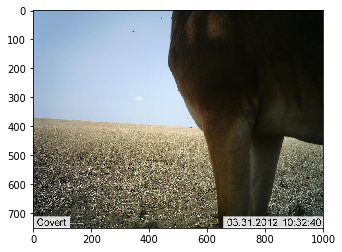

In [16]:
img = img0
encoded_jpg_io = io.BytesIO(img)
image = Image.open(encoded_jpg_io)
width, height = image.size
plt.imshow(image)
plt.show()

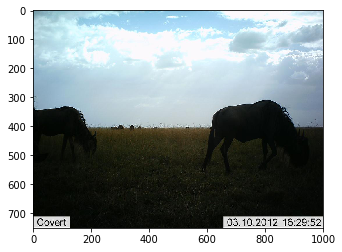

In [17]:
img = img1
encoded_jpg_io = io.BytesIO(img)
image = Image.open(encoded_jpg_io)
width, height = image.size
plt.imshow(image)
plt.show()

#### Creating the bounding boxes

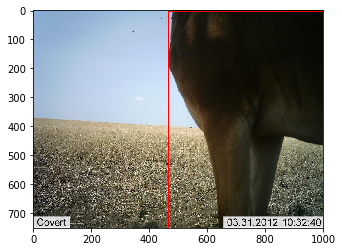

In [18]:
xmins = []
ymins = []
xmaxs = []
ymaxs = []
i = 0
for j in range(0, xmin[0].shape[0]):
    if xmin[0][j][0] == i:
        xmins.append(int(xmin[1][j]*1000))
        ymins.append(int(ymin[1][j]*750))
        xmaxs.append(int(xmax[1][j]*1000))
        ymaxs.append(int(ymax[1][j]*750))
        
img = img0
encoded_jpg_io = io.BytesIO(img)
image = Image.open(encoded_jpg_io)
width, height = image.size

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(image)
for s in range(len(xmins)):
    rect = patches.Rectangle((xmins[s],ymins[s]),(xmaxs[s]-xmins[s]), (ymaxs[s] - ymins[s]),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
plt.show()

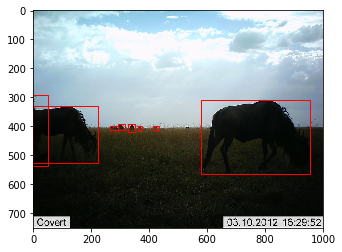

In [19]:
xmins = []
ymins = []
xmaxs = []
ymaxs = []
i = 1
for j in range(0, xmin[0].shape[0]):
    if xmin[0][j][0] == i:
        xmins.append(int(xmin[1][j]*1000))
        ymins.append(int(ymin[1][j]*750))
        xmaxs.append(int(xmax[1][j]*1000))
        ymaxs.append(int(ymax[1][j]*750))
        
img = img1
encoded_jpg_io = io.BytesIO(img)
image = Image.open(encoded_jpg_io)
width, height = image.size

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
# s = 6
ax.imshow(image)
for s in range(len(xmins)):
    rect = patches.Rectangle((xmins[s],ymins[s]),(xmaxs[s]-xmins[s]), (ymaxs[s] - ymins[s]),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

In [20]:
import inspect
lines = inspect.getsource(dataset_util.float_list_feature)
print(lines)

#dataset_util.int64_feature

def float_list_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

